# MLUL2 Group Assignment- Outlier Detection

Submitted by Group-12:
* Ojasvi Ashish Chauhan, 12320060
* Mahesh Chandankar, 12320037
* Kashika Sharda, 12320047
* Kriti Joshi, 12320021
* Maulin Shah, 12320030

## Brief Introduction

Dataset considered for 54 IT companies for the FY 22-23 Q4 ending period.

Total of 12 Ratios considered in this dataset. 

Ratios considered to identify outliers as below:
* Current ratio: Current Assets / Current Liabilities, Current ratio denoted by CR
* Debt to equity ratio: Total Debt / Total Equity, Debt to equity ratio denoted by DE
* Inventory turnover: Cost of goods sold / Average inventory, Inventory turnover denoted by IT.
* Return on equity (ROE): Net income / Total equity, Return on equity denoted by ROE.
* Operating margin: ( Gross profit - selling and admin exp - other exp - depriciation/ Net sales ), Operating margin denoted by OPR.
* Price earnings ratio (P/E): Share price / Earnings per share, Price earnings ratio denoted by PE.
* Book value per share ratio: (Total Equity – Preferred Equity) / Total shares outstanding, Book value per share ratio denoted by BVPS.
* Return on Capital Employed : EBT/( Equity + reserve + borrowings), Return on Capital Employed denoted by ROCE.
* Return on Assets: Net Income/ Total Assets, Return on Assets denoted by ROA.
* Quick Ratio: (Current assets- inventory)/Current liablities, Quick Ratio denoted by QR.
* Asset Turnover Ratio: Sales/Fixed assets, Asset Turnover Ratio denoted by ATR.
* Interest Coverage ratio: EBIT/Interest,Interest Coverage ratio denoted by ICR.

In [5]:
# importing libraries and prebuilt functions

import os

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading the data into dataframe

df=pd.read_csv(r"Outlier_Dataset.csv")

### EDA

In [10]:
# Describing Data

df.describe()

,CR,DE,IT,ROE,OPR,PE,BVPS,ROCE,ROA,QR,ATR,ICR
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,3.860370,0.222222,575.897407,0.158704,0.142963,33.269444,278.096296,0.244630,0.130000,3.739444,7.284444,43.750185
std,6.572549,0.366146,1504.810917,0.205252,0.094062,164.900179,530.606241,0.164118,0.086853,6.612478,12.502754,48.515411
min,0.000000,0.000000,0.000000,-0.840000,-0.050000,-1016.120000,11.820000,-0.280000,0.000000,0.000000,0.920000,-7.570000
25%,1.502500,0.030000,0.000000,0.122500,0.100000,24.247500,59.470000,0.182500,0.062500,1.412500,2.915000,11.495000
50%,2.620000,0.090000,3.150000,0.180000,0.140000,37.560000,136.840000,0.250000,0.110000,2.530000,4.080000,24.070000
75%,3.362500,0.240000,35.115000,0.247500,0.187500,59.687500,290.312500,0.330000,0.185000,3.335000,6.887500,56.632500
max,46.530000,2.120000,7677.760000,0.510000,0.420000,451.090000,3606.290000,0.660000,0.430000,46.530000,90.470000,203.990000


In [9]:
# Detect missing values

np.sum(df.isna())

Name    0
CR      0
DE      0
IT      0
ROE     0
OPR     0
PE      0
BVPS    0
ROCE    0
ROA     0
QR      0
ATR     0
ICR     0
dtype: int64

In [11]:
# Sample Data

df.sample(10)

,Name,CR,DE,IT,ROE,OPR,PE,BVPS,ROCE,ROA,QR,ATR,ICR
24,Newgen Software Technologies Ltd,3.12,0.04,0.00,0.18,0.20,59.68,132.15,0.24,0.14,3.12,4.00,54.53
27,Tanla Platforms Ltd,1.50,0.05,0.00,0.30,0.16,23.35,112.91,0.38,0.20,1.50,6.94,161.97
0,Tata Consultancy Services Ltd,2.53,0.09,4621.54,0.47,0.24,30.06,247.12,0.63,0.29,2.53,10.99,74.05
16,Cyient Ltd,2.80,0.35,9.20,0.16,0.13,31.70,313.52,0.21,0.10,2.80,2.13,8.06
34,Infibeam Avenues Ltd,1.41,0.00,0.00,0.04,0.06,56.89,11.82,0.08,0.04,1.41,0.92,85.75
18,Redington Ltd,1.31,0.48,11.44,-0.50,-0.04,7.03,88.63,-0.28,0.11,0.93,90.47,-7.57
36,Rategain Travel Technologies Ltd,19.55,0.02,0.00,0.10,0.09,60.95,65.52,0.14,0.01,19.55,1.43,20.33
1,Infosys Ltd,1.90,0.11,0.00,0.32,0.21,24.10,181.77,0.45,0.23,1.90,5.02,118.33
30,CE Info Systems Ltd,4.53,0.05,9.36,0.20,0.38,96.81,101.03,0.26,0.17,4.51,5.02,50.91
48,Hinduja Global Solutions Ltd,3.44,0.12,186.49,0.04,-0.05,36.97,1627.28,0.07,0.06,3.42,1.60,2.58


## Code

In [12]:
# Dropping Company Names

newdf=df.drop("Name",axis='columns')

In [13]:
# Create a results dataframe to store and later compare results

def fit_model(input_data, model_fn, model_args=None, threshold=0.15, labels=None):
    return model_fn(input_data, model_args, threshold, labels)

def predict_model(input_data, model, predict_fn, threshold=None):
    return predict_fn(input_data, model, threshold)

### Using LOF

In [14]:
# Data Normalization
# Create an instance of the StandardScaler
# Fit the scaler to the data and transform the data in one step

scaler = StandardScaler()
X = scaler.fit_transform(newdf)

We have used 4 different contamination level at 5%,10%,15% & 20%. For each contamination level, a new LOF model is created, fitted to the data, and used to predict outliers.

#### LOF@contamination 5%

In [37]:
clf = LocalOutlierFactor(n_neighbors=5, contamination=0.05)
df['Outlier'] = clf.fit_predict(X)
df['LOF Score'] = -clf.negative_outlier_factor_

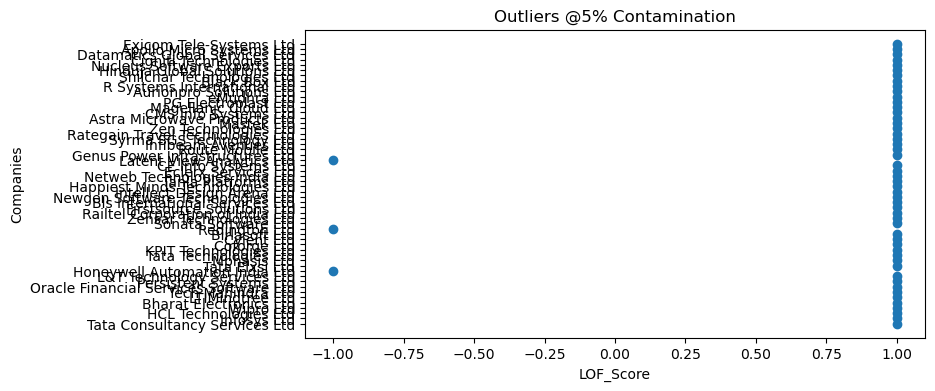

In [43]:
# Plotting the outliers

plt.figure(figsize=(8,4))
plt.scatter(df['Outlier'], df['Name'])
plt.title('Outliers @5% Contamination')
plt.xlabel('LOF_Score')
plt.ylabel('Companies')
plt.show()

In [44]:
outlier_companies = df[df['Outlier'] == -1]['Name']
print("Outlier Companies:")
print(outlier_companies.tolist())

Outlier Companies:
['Honeywell Automation India Ltd', 'Redington Ltd', 'Latent View Analytics Ltd']


* Analysis: At Contamination Level 5, we have found 3 companies in outliers. 

#### LOF@contamination 10%


In [27]:
clf = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
df['Outlier'] = clf.fit_predict(X)
df['LOF Score'] = -clf.negative_outlier_factor_
print(df)

                                      Name     CR    DE       IT   ROE   OPR  \
0            Tata Consultancy Services Ltd   2.53  0.09  4621.54  0.47  0.24   
1                              Infosys Ltd   1.90  0.11     0.00  0.32  0.21   
2                     HCL Technologies Ltd   2.68  0.07   329.17  0.22  0.18   
3                                Wipro Ltd   2.86  0.22   570.67  0.15  0.15   
4                   Bharat Electronics Ltd   1.46  0.00     2.04  0.16  0.16   
5                          LTIMindtree Ltd   3.23  0.09  7677.76  0.27  0.16   
6                        Tech Mahindra Ltd   1.81  0.10  1758.30  0.17  0.11   
7   Oracle Financial Services Software Ltd  10.10  0.01     0.00  0.24  0.42   
8                   Persistent Systems Ltd   3.07  0.17     0.00  0.23  0.15   
9              L&T Technology Services Ltd   3.49  0.10  3145.06  0.27  0.18   
10          Honeywell Automation India Ltd   3.34  0.01    15.28  0.13  0.13   
11                          Tata Elxsi L

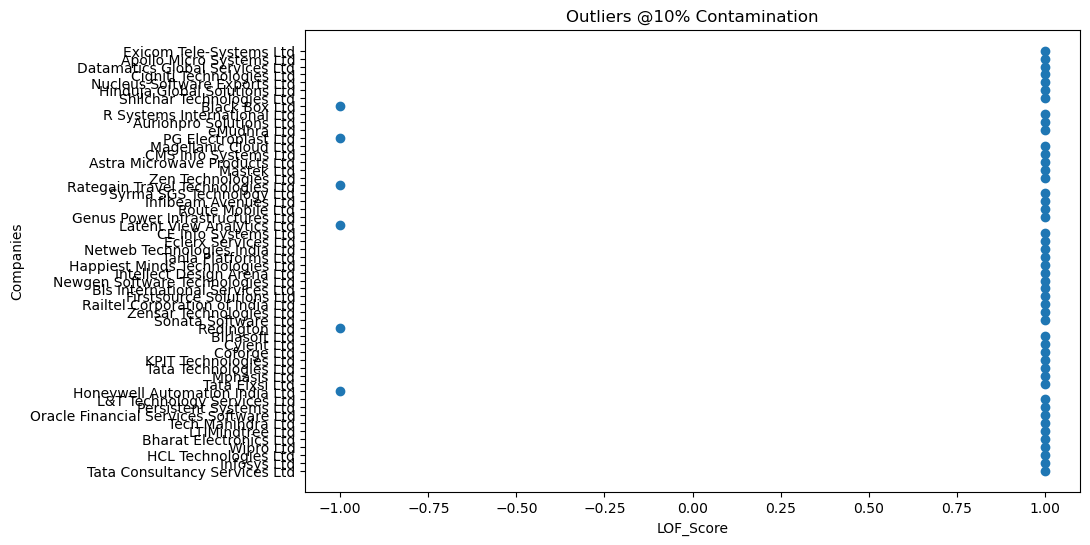

In [28]:
# Plotting the outliers

plt.figure(figsize=(10, 6))
plt.scatter(df['Outlier'], df['Name'])
plt.title('Outliers @10% Contamination')
plt.xlabel('LOF_Score')
plt.ylabel('Companies')
plt.show()

In [91]:
outlier_companies = df[df['Outlier'] == -1]['Name']
print("Outlier Companies:")
print(outlier_companies.tolist())

Outlier Companies:
['Honeywell Automation India Ltd', 'Redington Ltd', 'Latent View Analytics Ltd', 'Rategain Travel Technologies Ltd', 'PG Electroplast Ltd', 'Black Box Ltd']


Analysis: At contamination level 10%, we have found 6 companies in outliers. 

#### LOF@contamination 15%

In [29]:
clf = LocalOutlierFactor(n_neighbors=5, contamination=0.15)
df['Outlier'] = clf.fit_predict(X)
df['LOF Score'] = -clf.negative_outlier_factor_
print(df)

                                      Name     CR    DE       IT   ROE   OPR  \
0            Tata Consultancy Services Ltd   2.53  0.09  4621.54  0.47  0.24   
1                              Infosys Ltd   1.90  0.11     0.00  0.32  0.21   
2                     HCL Technologies Ltd   2.68  0.07   329.17  0.22  0.18   
3                                Wipro Ltd   2.86  0.22   570.67  0.15  0.15   
4                   Bharat Electronics Ltd   1.46  0.00     2.04  0.16  0.16   
5                          LTIMindtree Ltd   3.23  0.09  7677.76  0.27  0.16   
6                        Tech Mahindra Ltd   1.81  0.10  1758.30  0.17  0.11   
7   Oracle Financial Services Software Ltd  10.10  0.01     0.00  0.24  0.42   
8                   Persistent Systems Ltd   3.07  0.17     0.00  0.23  0.15   
9              L&T Technology Services Ltd   3.49  0.10  3145.06  0.27  0.18   
10          Honeywell Automation India Ltd   3.34  0.01    15.28  0.13  0.13   
11                          Tata Elxsi L

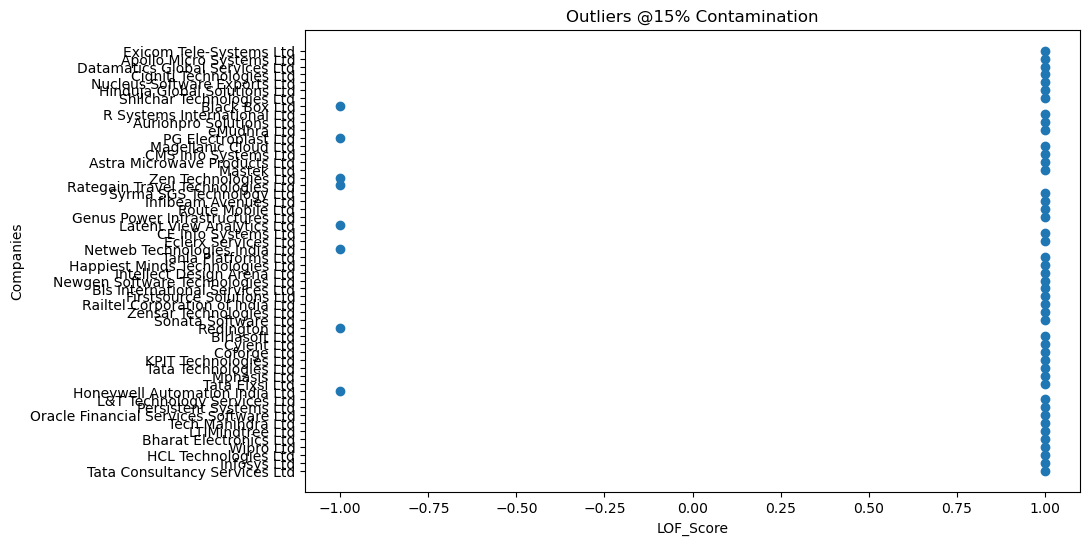

In [30]:
# Plotting the outliers

plt.figure(figsize=(10, 6))
plt.scatter(df['Outlier'], df['Name'])
plt.title('Outliers @15% Contamination')
plt.xlabel('LOF_Score')
plt.ylabel('Companies')
plt.show()

In [31]:
outlier_companies = df[df['Outlier'] == -1]['Name']
print("Outlier Companies:")
print(outlier_companies.tolist())

Outlier Companies:
['Honeywell Automation India Ltd', 'Redington Ltd', 'Netweb Technologies India Ltd', 'Latent View Analytics Ltd', 'Rategain Travel Technologies Ltd', 'Zen Technologies Ltd', 'PG Electroplast Ltd', 'Black Box Ltd']


Analysis: At contamination level 15%, we have found 8 companies in outliers. 

#### LOF@contamination 20%

In [45]:
clf = LocalOutlierFactor(n_neighbors=5, contamination=0.20)
df['Outlier'] = clf.fit_predict(X)
df['LOF Score'] = -clf.negative_outlier_factor_
print(df)

                                      Name     CR    DE       IT   ROE   OPR  \
0            Tata Consultancy Services Ltd   2.53  0.09  4621.54  0.47  0.24   
1                              Infosys Ltd   1.90  0.11     0.00  0.32  0.21   
2                     HCL Technologies Ltd   2.68  0.07   329.17  0.22  0.18   
3                                Wipro Ltd   2.86  0.22   570.67  0.15  0.15   
4                   Bharat Electronics Ltd   1.46  0.00     2.04  0.16  0.16   
5                          LTIMindtree Ltd   3.23  0.09  7677.76  0.27  0.16   
6                        Tech Mahindra Ltd   1.81  0.10  1758.30  0.17  0.11   
7   Oracle Financial Services Software Ltd  10.10  0.01     0.00  0.24  0.42   
8                   Persistent Systems Ltd   3.07  0.17     0.00  0.23  0.15   
9              L&T Technology Services Ltd   3.49  0.10  3145.06  0.27  0.18   
10          Honeywell Automation India Ltd   3.34  0.01    15.28  0.13  0.13   
11                          Tata Elxsi L

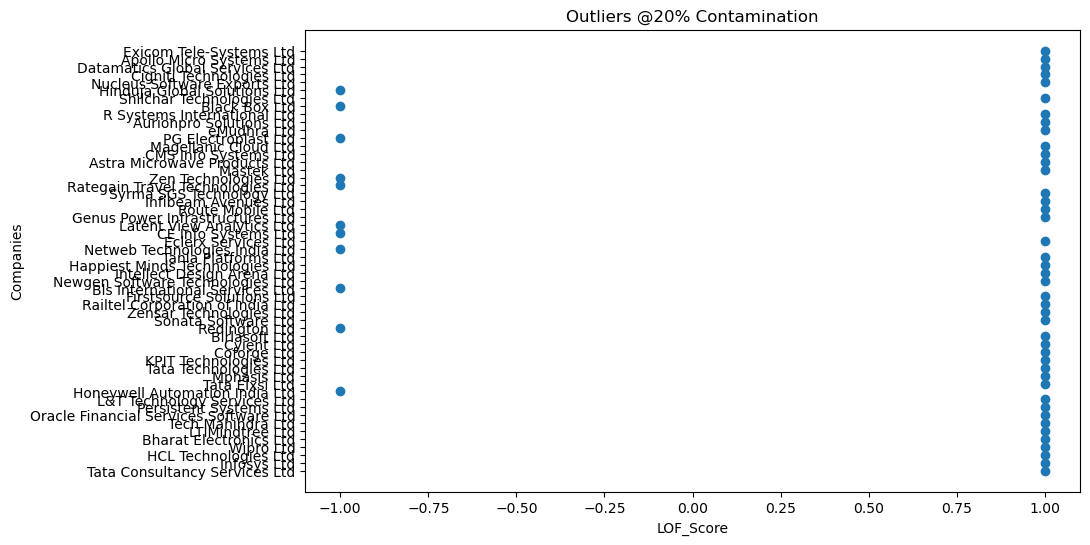

In [46]:
# Plotting the outliers

plt.figure(figsize=(10, 6))
plt.scatter(df['Outlier'], df['Name'])
plt.title('Outliers @20% Contamination')
plt.xlabel('LOF_Score')
plt.ylabel('Companies')
plt.show()

In [35]:
outlier_companies = df[df['Outlier'] == -1]['Name']
print("Outlier Companies:")
print(outlier_companies.tolist())

Outlier Companies:
['Honeywell Automation India Ltd', 'Redington Ltd', 'Bls International Services Ltd', 'Netweb Technologies India Ltd', 'CE Info Systems Ltd', 'Latent View Analytics Ltd', 'Rategain Travel Technologies Ltd', 'Zen Technologies Ltd', 'PG Electroplast Ltd', 'Black Box Ltd', 'Hinduja Global Solutions Ltd']


Analysis: At contamination level 20%, we have found 11 companies in outliers. 

#### Interpretation @contamination 20%

In [57]:
# Data for outlier companies

df[df['Outlier'] == -1]

,Name,CR,DE,IT,ROE,OPR,PE,BVPS,ROCE,ROA,QR,ATR,ICR,Outlier,LOF Score
10,Honeywell Automation India Ltd,3.34,0.01,15.28,0.13,0.13,99.76,3606.29,0.19,0.10,3.20,22.85,86.75,-1,4.701914
18,Redington Ltd,1.31,0.48,11.44,-0.50,-0.04,7.03,88.63,-0.28,0.11,0.93,90.47,-7.57,-1,4.293931
23,Bls International Services Ltd,2.94,0.01,2106.29,0.25,0.13,44.68,19.54,0.30,0.43,2.94,6.49,86.79,-1,1.872935
28,Netweb Technologies India Ltd,0.00,0.38,6.60,0.48,0.15,353.46,18.39,0.50,0.00,0.00,19.05,16.04,-1,2.699845
30,CE Info Systems Ltd,4.53,0.05,9.36,0.20,0.38,96.81,101.03,0.26,0.17,4.51,5.02,50.91,-1,1.575106
31,Latent View Analytics Ltd,46.53,0.02,0.00,0.13,0.25,66.89,58.93,0.16,0.12,46.53,23.23,69.86,-1,4.966854
36,Rategain Travel Technologies Ltd,19.55,0.02,0.00,0.10,0.09,60.95,65.52,0.14,0.01,19.55,1.43,20.33,-1,2.771178
37,Zen Technologies Ltd,2.69,0.02,3.12,0.03,0.12,451.09,39.45,0.12,0.08,2.36,2.91,8.82,-1,2.199688
42,PG Electroplast Ltd,1.36,1.46,5.66,0.05,0.04,-1016.12,174.09,0.08,0.06,0.87,3.74,1.86,-1,3.846810
46,Black Box Ltd,1.30,2.12,16.31,-0.84,-0.02,12.15,17.63,-0.15,0.01,1.23,7.92,-1.18,-1,3.592921


In [58]:
# data description for outlier companies

df[df['Outlier'] == -1].describe()

,CR,DE,IT,ROE,OPR,PE,BVPS,ROCE,ROA,QR,ATR,ICR,Outlier,LOF Score
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.000000
mean,7.908182,0.426364,214.595455,0.006364,0.107273,19.424545,528.798182,0.126364,0.104545,7.776364,16.791818,30.471818,-1.0,3.139015
std,13.870675,0.708481,629.720263,0.365630,0.128537,372.537127,1124.107979,0.209727,0.119947,13.934409,25.816602,36.240394,0.0,1.198457
min,0.000000,0.010000,0.000000,-0.840000,-0.050000,-1016.120000,17.630000,-0.280000,0.000000,0.000000,1.430000,-7.570000,-1.0,1.575106
25%,1.335000,0.020000,4.390000,0.035000,0.010000,24.560000,29.495000,0.075000,0.035000,1.080000,3.325000,2.220000,-1.0,2.103836
50%,2.940000,0.050000,9.360000,0.100000,0.120000,60.950000,65.520000,0.140000,0.080000,2.940000,6.490000,16.040000,-1.0,2.771178
75%,3.985000,0.430000,15.795000,0.165000,0.140000,98.285000,137.560000,0.225000,0.115000,3.965000,20.950000,60.385000,-1.0,4.070371
max,46.530000,2.120000,2106.290000,0.480000,0.380000,451.090000,3606.290000,0.500000,0.430000,46.530000,90.470000,86.790000,-1.0,4.966854


In [59]:
# data description of non-outlier companies

df[df['Outlier'] == 1].describe()

,CR,DE,IT,ROE,OPR,PE,BVPS,ROCE,ROA,QR,ATR,ICR,Outlier,LOF Score
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.0,43.000000
mean,2.824884,0.170000,668.323488,0.197674,0.152093,36.811163,213.963256,0.274884,0.136512,2.706744,4.852326,47.146977,1.0,1.191819
std,1.820651,0.189624,1649.295848,0.117044,0.082536,34.741451,183.702907,0.137536,0.076684,1.893712,2.973230,50.985344,0.0,0.208392
min,1.000000,0.000000,0.000000,-0.140000,-0.050000,-97.720000,11.820000,-0.060000,0.020000,0.610000,0.920000,-0.720000,1.0,0.959094
25%,1.535000,0.040000,0.000000,0.150000,0.105000,24.395000,73.945000,0.210000,0.070000,1.450000,2.875000,14.985000,1.0,1.004725
50%,2.560000,0.090000,1.630000,0.190000,0.150000,32.940000,162.710000,0.260000,0.140000,2.530000,4.000000,27.210000,1.0,1.142292
75%,3.175000,0.230000,81.600000,0.265000,0.195000,57.120000,302.525000,0.335000,0.195000,3.175000,6.710000,56.365000,1.0,1.386411
max,10.100000,0.730000,7677.760000,0.510000,0.420000,97.900000,863.330000,0.660000,0.290000,10.100000,12.570000,203.990000,1.0,1.569989


Logic to identify Outliers:
* Step1 - First Mean, Standard Deviation for each feature has been calculated.
* Step2 - Range of Mean has been calculated, i.e., min value and max value of mean. This has been identified with the help of Mean and Standard Deviation. (Mean-/+standard deviation) will give mean value and max value .
* Step3 - If the feature value of the identified company is outside the calculated range values of the mean of the dataset, then the said company is outlier due to a particular feature. 

In [66]:
new_df=df.drop(["Name"],axis=1)

In [68]:
# creating a dataframe with mean, std deviation & Minimum, Maximum value of standard deviation.

df2 = pd.DataFrame(new_df.mean(),columns=["mean_value"])
df2["stand_dev"]=new_df.std()
df2["min_value"]=df2.mean_value-df2["stand_dev"]
df2["max_value"]=df2.mean_value+df2["stand_dev"]
df2=df2.T
df2.head(5)

,CR,DE,IT,ROE,OPR,PE,BVPS,ROCE,ROA,QR,ATR,ICR,Outlier,LOF Score
mean_value,3.860370,0.222222,575.897407,0.158704,0.142963,33.269444,278.096296,0.244630,0.130000,3.739444,7.284444,43.750185,0.592593,1.588470
stand_dev,6.572549,0.366146,1504.810917,0.205252,0.094062,164.900179,530.606241,0.164118,0.086853,6.612478,12.502754,48.515411,0.813066,0.965424
min_value,-2.712178,-0.143924,-928.913509,-0.046549,0.048901,-131.630734,-252.509945,0.080511,0.043147,-2.873034,-5.218309,-4.765226,-0.220473,0.623046
max_value,10.432919,0.588368,2080.708324,0.363956,0.237025,198.169623,808.702538,0.408748,0.216853,10.351922,19.787198,92.265596,1.405659,2.553894


In [69]:
# Creating a list of the outlier companies by comparing feature value of outlier company with minimum values and maximum value of (mean-/+standard deviation)

def function_a(row,df2): 
    strg=[]
    for col in df.columns[1:-2]:
        if ((row[col]>df2[col][-1])or(row[col]<df2[col][-2])):
            strg.append(col)
    return strg

In [70]:
# Removing outlier and LOF columns from the dataset

final_df=df[df.Outlier==-1].iloc[:,:-2]

In [71]:
final_df

,Name,CR,DE,IT,ROE,OPR,PE,BVPS,ROCE,ROA,QR,ATR,ICR
10,Honeywell Automation India Ltd,3.34,0.01,15.28,0.13,0.13,99.76,3606.29,0.19,0.10,3.20,22.85,86.75
18,Redington Ltd,1.31,0.48,11.44,-0.50,-0.04,7.03,88.63,-0.28,0.11,0.93,90.47,-7.57
23,Bls International Services Ltd,2.94,0.01,2106.29,0.25,0.13,44.68,19.54,0.30,0.43,2.94,6.49,86.79
28,Netweb Technologies India Ltd,0.00,0.38,6.60,0.48,0.15,353.46,18.39,0.50,0.00,0.00,19.05,16.04
30,CE Info Systems Ltd,4.53,0.05,9.36,0.20,0.38,96.81,101.03,0.26,0.17,4.51,5.02,50.91
31,Latent View Analytics Ltd,46.53,0.02,0.00,0.13,0.25,66.89,58.93,0.16,0.12,46.53,23.23,69.86
36,Rategain Travel Technologies Ltd,19.55,0.02,0.00,0.10,0.09,60.95,65.52,0.14,0.01,19.55,1.43,20.33
37,Zen Technologies Ltd,2.69,0.02,3.12,0.03,0.12,451.09,39.45,0.12,0.08,2.36,2.91,8.82
42,PG Electroplast Ltd,1.36,1.46,5.66,0.05,0.04,-1016.12,174.09,0.08,0.06,0.87,3.74,1.86
46,Black Box Ltd,1.30,2.12,16.31,-0.84,-0.02,12.15,17.63,-0.15,0.01,1.23,7.92,-1.18


In [72]:
final_df.apply(function_a,axis=1,args=(df2,))

10                   [BVPS, ATR]
18    [ROE, OPR, ROCE, ATR, ICR]
23                     [IT, ROA]
28          [ROE, PE, ROCE, ROA]
30                         [OPR]
31            [CR, OPR, QR, ATR]
36                 [CR, ROA, QR]
37                          [PE]
42           [DE, OPR, PE, ROCE]
46     [DE, ROE, OPR, ROCE, ROA]
48             [OPR, BVPS, ROCE]
dtype: object

Interpretation:

At contamination level 20%, we have found 11 companies in outliers. 
    
* Honeywell Automation India Ltd is an outlier due to BVPS & ATR, since values of BVPS & ATR are lying outside the range (Min & Max value) as observed above. 

BVPS is 3606.29 while BVPS range is Min Value:-252.50 & Max Value:808.70. 

Similarly ATR is 22.85 while ATR range is Min Value:-5.21 & Max Value:19.78.

Other companies are outliers due to various factors as mentioned below:

* Redington Ltd is an outlier due to ROE, OPR, ROCE, ATR, ICR. 
* Bls International Services Ltd is an outlier due to IT, ROA. 
* Netweb Technologies India Ltd is an outlier due to ROE, PE, ROCE, ROA. 
* CE Info Systems Ltd is an outlier due to OPR. 
* Latent View Analytics Ltd is an outlier due to CR, OPR, QR, ATR. 
* Rategain Travel Technologies Ltd is an outlier due to CR, ROA, QR. 
* Zen Technologies Ltd is an outlier due to PE. 
* PG Electroplast Ltd is an outlier due to DE, OPR, PE, ROCE. 
* Black Box Ltd is an outlier due to DE, ROE, OPR, ROCE, ROA. 
* Hinduja Global Solutions Ltd is an outlier due to OPR, BVPS, ROCE. 

In [149]:
df2.describe()

,CR,DE,IT,ROE,OPR,PE,BVPS,ROCE,ROA,QR,ATR,ICR,Outlier,LOF Score
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,4.945242,0.279792,947.462811,0.177323,0.123403,85.921738,379.100274,0.212425,0.112741,4.888658,9.371768,45.656276,0.680782,1.339252
std,4.879136,0.270639,1179.445649,0.147358,0.071702,137.091318,399.874822,0.124145,0.065804,4.933430,9.291321,34.404720,0.587470,0.763202
min,-2.712178,-0.143924,-928.913509,-0.046549,0.048901,-131.630734,-252.509945,0.080511,0.043147,-2.873034,-5.218309,-4.765226,-0.220473,0.623046
25%,3.860370,0.222222,575.897407,0.158704,0.094062,33.269444,278.096296,0.164118,0.086853,3.739444,7.284444,43.750185,0.592593,0.965424
50%,6.572549,0.366146,1504.810917,0.205252,0.094062,164.900179,530.606241,0.164118,0.086853,6.612478,12.502754,48.515411,0.813066,0.965424
75%,6.572549,0.366146,1504.810917,0.205252,0.142963,164.900179,530.606241,0.244630,0.130000,6.612478,12.502754,48.515411,0.813066,1.588470
max,10.432919,0.588368,2080.708324,0.363956,0.237025,198.169623,808.702538,0.408748,0.216853,10.351922,19.787198,92.265596,1.405659,2.553894


### Using Isolation Forest

#### Isolation Forest@contamination 5%

In [107]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
isolation_forest.fit(newdf)
df['anomaly'] = isolation_forest.predict(newdf)
df['anomaly_score'] = isolation_forest.decision_function(newdf)
outliers = df[df['anomaly'] == -1]
print(outliers["Name"].tolist())

['Oracle Financial Services Software Ltd', 'Redington Ltd', 'Latent View Analytics Ltd']


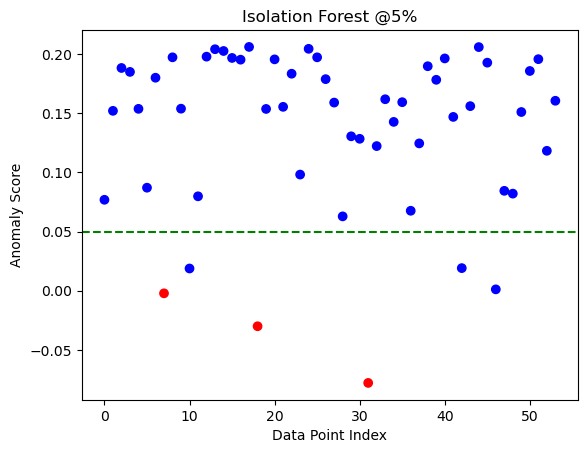

In [108]:
plt.scatter(range(len(X)), df.anomaly_score, c=['r' if x == -1 else 'b' for x in df.anomaly])
plt.axhline(y=0.05, color='g', linestyle='--')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.title('Isolation Forest @5%')
plt.show()

#### Isolation Forest@contamination 10%

In [109]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
isolation_forest.fit(newdf)
df['anomaly'] = isolation_forest.predict(newdf)
df['anomaly_score'] = isolation_forest.decision_function(newdf)
outliers = df[df['anomaly'] == -1]
print(outliers["Name"].tolist())

['Oracle Financial Services Software Ltd', 'Honeywell Automation India Ltd', 'Redington Ltd', 'Latent View Analytics Ltd', 'PG Electroplast Ltd', 'Black Box Ltd']


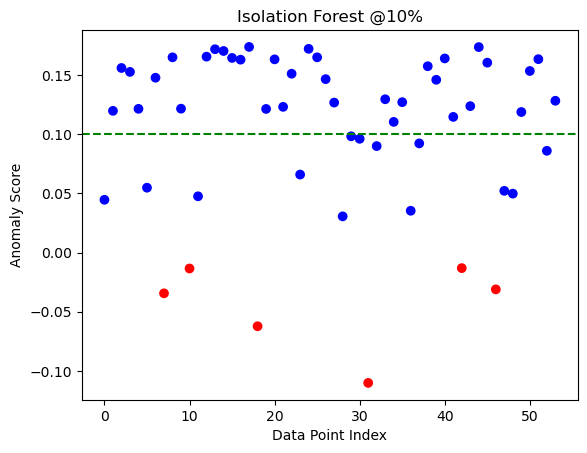

In [111]:
plt.scatter(range(len(X)), df.anomaly_score, c=['r' if x == -1 else 'b' for x in df.anomaly])
plt.axhline(y=0.1, color='g', linestyle='--')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.title('Isolation Forest @10%')
plt.show()

#### Isolation Forest@contamination 15%

In [112]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.15, random_state=42)
isolation_forest.fit(newdf)
df['anomaly'] = isolation_forest.predict(newdf)
df['anomaly_score'] = isolation_forest.decision_function(newdf)
outliers = df[df['anomaly'] == -1]
print(outliers["Name"].tolist())

['Oracle Financial Services Software Ltd', 'Honeywell Automation India Ltd', 'Redington Ltd', 'Netweb Technologies India Ltd', 'Latent View Analytics Ltd', 'Rategain Travel Technologies Ltd', 'PG Electroplast Ltd', 'Black Box Ltd']


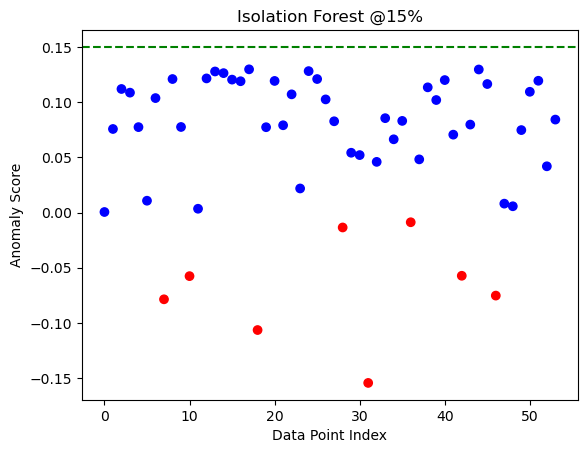

In [115]:
plt.scatter(range(len(X)), df.anomaly_score, c=['r' if x == -1 else 'b' for x in df.anomaly])
plt.axhline(y=0.15, color='g', linestyle='--')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.title('Isolation Forest @15%')
plt.show()

#### Isolation Forest@contamination 20%

In [116]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.2, random_state=42)
isolation_forest.fit(newdf)
df['anomaly'] = isolation_forest.predict(newdf)
df['anomaly_score'] = isolation_forest.decision_function(newdf)
outliers = df[df['anomaly'] == -1]
print(outliers["Name"].tolist())

['Tata Consultancy Services Ltd', 'Oracle Financial Services Software Ltd', 'Honeywell Automation India Ltd', 'Tata Elxsi Ltd', 'Redington Ltd', 'Netweb Technologies India Ltd', 'Latent View Analytics Ltd', 'Rategain Travel Technologies Ltd', 'PG Electroplast Ltd', 'Black Box Ltd', 'Hinduja Global Solutions Ltd']


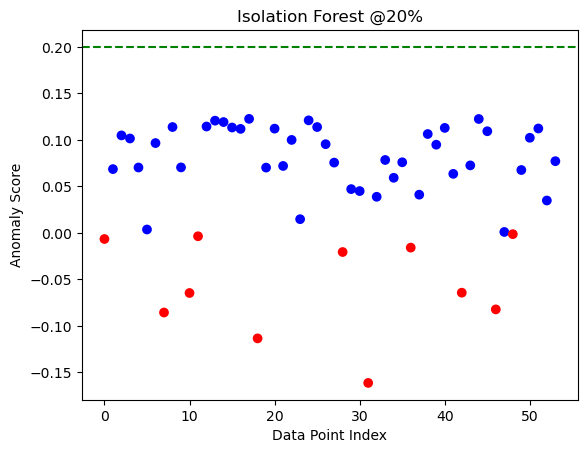

In [117]:
plt.scatter(range(len(X)), df.anomaly_score, c=['r' if x == -1 else 'b' for x in df.anomaly])
plt.axhline(y=0.2, color='g', linestyle='--')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.title('Isolation Forest @20%')
plt.show()

#### Interpretation at @contamination 20%

In [122]:
df[df.anomaly==-1]

,Name,CR,DE,IT,ROE,OPR,PE,BVPS,ROCE,ROA,QR,ATR,ICR,Outlier,LOF Score,anomaly,anomaly_score
0,Tata Consultancy Services Ltd,2.53,0.09,4621.54,0.47,0.24,30.06,247.12,0.63,0.29,2.53,10.99,74.05,1,1.142292,-1,-0.006624
7,Oracle Financial Services Software Ltd,10.10,0.01,0.00,0.24,0.42,38.15,863.33,0.35,0.27,10.10,6.73,203.99,1,1.566285,-1,-0.085702
10,Honeywell Automation India Ltd,3.34,0.01,15.28,0.13,0.13,99.76,3606.29,0.19,0.10,3.20,22.85,86.75,-1,4.701914,-1,-0.064712
11,Tata Elxsi Ltd,4.83,0.09,4809.62,0.36,0.28,57.15,334.92,0.45,0.27,4.83,9.43,55.24,1,1.077150,-1,-0.003678
18,Redington Ltd,1.31,0.48,11.44,-0.50,-0.04,7.03,88.63,-0.28,0.11,0.93,90.47,-7.57,-1,4.293931,-1,-0.113536
28,Netweb Technologies India Ltd,0.00,0.38,6.60,0.48,0.15,353.46,18.39,0.50,0.00,0.00,19.05,16.04,-1,2.699845,-1,-0.020638
31,Latent View Analytics Ltd,46.53,0.02,0.00,0.13,0.25,66.89,58.93,0.16,0.12,46.53,23.23,69.86,-1,4.966854,-1,-0.161452
36,Rategain Travel Technologies Ltd,19.55,0.02,0.00,0.10,0.09,60.95,65.52,0.14,0.01,19.55,1.43,20.33,-1,2.771178,-1,-0.015903
42,PG Electroplast Ltd,1.36,1.46,5.66,0.05,0.04,-1016.12,174.09,0.08,0.06,0.87,3.74,1.86,-1,3.846810,-1,-0.064387
46,Black Box Ltd,1.30,2.12,16.31,-0.84,-0.02,12.15,17.63,-0.15,0.01,1.23,7.92,-1.18,-1,3.592921,-1,-0.082346


Interpretation:

At contamination level 20%, we have found 11 companies in outliers(refer to Figure 15):

* For Oracle Financial Services Software Ltd, the company shows strong financial health with a very high BVPS (863.33) and a significant PE ratio (38.15). This suggests it is potentially overvalued or has strong market expectations.

* Honeywell Automation India Ltd, is an outlier mainly due to its exceptionally high BVPS (3606.29). This could indicate a high valuation of its assets.

* Redington Ltd has negative ROE (-0.50) and ROCE (-0.28), which are strong indicators of financial distress or operational inefficiency. These metrics are likely driving its classification as an anomaly.

* Netweb Technologies India Ltd stands out due to a very low debt-to-equity ratio (0.00) and high BVPS (353.46). The absence of debt could indicate a conservative financing strategy or limited access to debt markets.

* Latent View Analytics Ltd has an extremely high current ratio (46.53) and zero debt, suggesting the company has a large amount of liquid assets relative to its liabilities and no leverage. This might indicate inefficiency in using its assets.

* Rategain Travel Technologies Ltd has a high current ratio (19.55) and significant PE ratio (60.95) indicates strong liquidity and high market valuation. The company might be seen as having strong future growth potential but could also be overvalued.

* PG Electroplast Ltd has a negative BVPS (-1016.12) points to potential financial instability or significant liabilities exceeding its assets. This is a critical indicator of financial distress.

* Black Box Ltd has a high debt-to-equity ratio (2.12) and negative ROE (-0.84) signals high leverage and poor profitability. These factors contribute to its classification as an outlier and suggest potential financial troubles.

* Tata Elxsi is marked as an anomaly due to its high inventory turnover ratio, indicating efficient management of inventory but also potential overvaluation. 

* Latent View Analytics Ltd has The extremely high current ratio implies that the company holds a lot of liquid assets compared to its liabilities, which could indicate inefficiency in utilizing its assets. The lack of debt suggests a very conservative financing strategy or potential issues with accessing debt markets.

* Hinduja Global Solutions Ltd is flagged as an anomaly primarily due to its high book value per share, indicating a high valuation of assets. The LOF score suggests it is somewhat isolated compared to its neighbors in the dataset, potentially due to the high asset valuation.


### Comparison

In [131]:
# Companies detected as outliers by both the algorithms

df.query('anomaly == -1 and Outlier ==-1')

,Name,CR,DE,IT,ROE,OPR,PE,BVPS,ROCE,ROA,QR,ATR,ICR,Outlier,LOF Score,anomaly,anomaly_score
10,Honeywell Automation India Ltd,3.34,0.01,15.28,0.13,0.13,99.76,3606.29,0.19,0.10,3.20,22.85,86.75,-1,4.701914,-1,-0.064712
18,Redington Ltd,1.31,0.48,11.44,-0.50,-0.04,7.03,88.63,-0.28,0.11,0.93,90.47,-7.57,-1,4.293931,-1,-0.113536
28,Netweb Technologies India Ltd,0.00,0.38,6.60,0.48,0.15,353.46,18.39,0.50,0.00,0.00,19.05,16.04,-1,2.699845,-1,-0.020638
31,Latent View Analytics Ltd,46.53,0.02,0.00,0.13,0.25,66.89,58.93,0.16,0.12,46.53,23.23,69.86,-1,4.966854,-1,-0.161452
36,Rategain Travel Technologies Ltd,19.55,0.02,0.00,0.10,0.09,60.95,65.52,0.14,0.01,19.55,1.43,20.33,-1,2.771178,-1,-0.015903
42,PG Electroplast Ltd,1.36,1.46,5.66,0.05,0.04,-1016.12,174.09,0.08,0.06,0.87,3.74,1.86,-1,3.846810,-1,-0.064387
46,Black Box Ltd,1.30,2.12,16.31,-0.84,-0.02,12.15,17.63,-0.15,0.01,1.23,7.92,-1.18,-1,3.592921,-1,-0.082346
48,Hinduja Global Solutions Ltd,3.44,0.12,186.49,0.04,-0.05,36.97,1627.28,0.07,0.06,3.42,1.60,2.58,-1,2.007984,-1,-0.001417


Both Isolation Forest and LOF methods are effective in identifying outliers, with LOF being more sensitive to local deviations. Companies flagged by both methods generally exhibit extreme financial metrics, such as high or negative asset valuations, high liquidity ratios, and poor profitability metrics. 

Both algorithms consistently flag companies with extreme values in key financial metrics, such as high or negative BVPS, high CR, high DE, and poor profitability metrics.

LOF scores tend to be higher for more pronounced outliers, indicating greater sensitivity to local data density compared to Isolation Forest, which provides a more global perspective.

Both the methods mostly agree on which companies are outliers.

Common Companies detected as outliers:

* Black Box Ltd  
* Hinduja Global Solutions Ltd
* Honeywell Automation India Ltd  
* Latent View Analytics Ltd  
* Netweb Technologies India Ltd  
* PG Electroplast Ltd  
* Rategain Travel Technologies Ltd  
* Redington Ltd  